뽑는 것은 성공은 했는데
조건 추가는 하지 못함
맞는것하고 틀린것만 추론 가능..

In [1]:
import json
import os

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image

/data/ephemeral/home/streamlit/.venv/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def read_data_from_json_by_columns(filename):
    data = {}
    for key in filename:
        if type(filename[key]) == list:
            data[key] = pd.DataFrame(filename[key])
        else:
            data[key] = pd.DataFrame([filename[key]])
    return data

In [3]:
def load_json_data():
    with open('../dataset/train.json') as t:
        train_data = json.loads(t.read())
    with open('../dataset/val_split.json') as t:
        val_data = json.loads(t.read())
    with open('../dataset/test.json') as t:
        test_data = json.loads(t.read())
    test = read_data_from_json_by_columns(test_data)
    val = read_data_from_json_by_columns(val_data)
    train = read_data_from_json_by_columns(train_data)
    train['images']['annotation_num'] = train['annotations']['image_id'].value_counts()
    val['images']['annotation_num'] = val['annotations']['image_id'].value_counts()

    return test,val,  train, test_data, val_data, train_data


def csv_to_dataframe(dir, csv_file):
    file_path = os.path.join(dir, csv_file)  # 파일 경로 생성
    df = pd.read_csv(file_path)  # csv 파일을 DataFrame으로 불러오기
    df['image_id'] = df['image_id'].str.extract(r"(\d+)").astype(int)
    annotation = []
    ann_id = 0
    
    # 각 파일의 내용 처리
    for row in df.itertuples(index=False, name=None):
        img = row[1]  # image_id
        pred_str = row[0]  # PredictionString

        # PredictionString이 NaN일 경우 스킵
        if pd.isna(pred_str):
            continue
        
        pred = list(map(float, pred_str.split()))
        
        # 예측값을 6개씩 묶어서 처리
        for j in range(0, len(pred), 6):
            if j + 5 >= len(pred):  # 인덱스 범위 체크
                continue
            
            category_id = int(pred[j])
            confidence = pred[j + 1]
            bbox = (pred[j + 2], pred[j + 3], pred[j + 4]-pred[j + 2], pred[j + 5]-pred[j + 3])  # (x, y, w, h)
            area = pred[j + 4] * pred[j + 5]  # 넓이 계산 (w * h)

            # annotation 리스트에 추가
            annotation.append({
                "image_id": img,
                "category_id": category_id,
                "area": area,
                "bbox": bbox,
                "isclowd": 0,
                "id": ann_id,
                "confidence": confidence
            })
            
            ann_id += 1
    
    anno = pd.DataFrame(annotation)
    
    return anno


def coco_to_voc(coco_bbox):
    """
    Convert COCO bounding box format to Pascal VOC format.

    Parameters:
    coco_bbox (list of floats): COCO bbox [x_min, y_min, width, height]

    Returns:
    list of floats: Pascal VOC bbox [x_min, y_min, x_max, y_max]
    """
    x_min, y_min, width, height = coco_bbox
    x_max = x_min + width
    y_max = y_min + height
    return [x_min, y_min, x_max, y_max]





def draw_bbox(image_path, bbox, color='red'):
    # 이미지 로드
    image = Image.open(image_path)
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()
    
    # COCO 형식을 VOC 형식으로 변환
    #bbox = coco_to_voc(bbox)
    
    # matplotlib rectangle 생성 및 추가
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    
    plt.show()



def iou(box1, box2):
    """IoU 계산 함수"""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return interArea / float(box1Area + box2Area - interArea)

In [4]:
test,val,  train, test_data, val_data, train_data = load_json_data()
dir = 'valid'
choose_csv = 'co_dino_5scale_r50_lsj_8xb2_1x_coco.csv'
bbox_prediction = csv_to_dataframe(dir,choose_csv)

In [5]:
display(train['annotations'])
display(bbox_prediction.head())

,image_id,category_id,area,bbox,iscrowd,id
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4
...,...,...,...,...,...,...
23139,4882,5,768591.81,"[0.0, 116.2, 944.1, 814.1]",0,23139
23140,4882,7,57309.72,"[302.1, 439.3, 265.2, 216.1]",0,23140
23141,4882,0,1772.74,"[511.3, 451.1, 58.7, 30.2]",0,23141
23142,4882,1,53008.67,"[255.0, 421.4, 271.7, 195.1]",0,23142


,image_id,category_id,area,bbox,isclowd,id,confidence
0,1149,1,50496.331957,"(342.8173522949219, 61.15715408325195, 49.6199...",0,0,0.832823
1,1149,7,812205.125000,"(167.82858276367188, 360.24969482421875, 625.3...",0,1,0.110140
2,1149,7,32399.413990,"(365.6261901855469, 41.36286926269531, 29.9694...",0,2,0.093604
3,1149,7,74263.805690,"(205.99795532226562, 184.37374877929688, 85.06...",0,3,0.082686
4,1149,7,70197.963503,"(341.77197265625, 40.843994140625, 187.8439331...",0,4,0.080763


In [6]:
train_df = train['annotations']
unique_image_ids = bbox_prediction['image_id'].unique()

bbox_Truth = train_df[train_df['image_id'].isin(unique_image_ids)]

In [7]:
bbox_T_1149= bbox_Truth[bbox_Truth['image_id']== 1149]
bbox_P_1149 = bbox_prediction[bbox_prediction['image_id'] == 1149]
bbox_P_1149['bbox'] = bbox_P_1149['bbox'].apply(lambda x: list(x))

bbox_T_1149['bbox'] = bbox_T_1149['bbox'].apply(lambda x: coco_to_voc(x))
bbox_P_1149['bbox'] = bbox_P_1149['bbox'].apply(lambda x: coco_to_voc(x))



/tmp/ipykernel_86738/605425365.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_P_1149['bbox'] = bbox_P_1149['bbox'].apply(lambda x: list(x))
/tmp/ipykernel_86738/605425365.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_T_1149['bbox'] = bbox_T_1149['bbox'].apply(lambda x: coco_to_voc(x))
/tmp/ipykernel_86738/605425365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

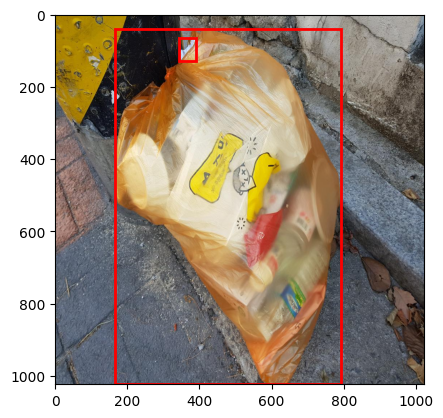

In [8]:
image_path = '/data/ephemeral/home/dataset/train/1149.jpg'
image = Image.open(image_path)
plt.figure()
plt.imshow(image)
ax = plt.gca()
    
for bbox in bbox_T_1149['bbox']:
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
plt.show()

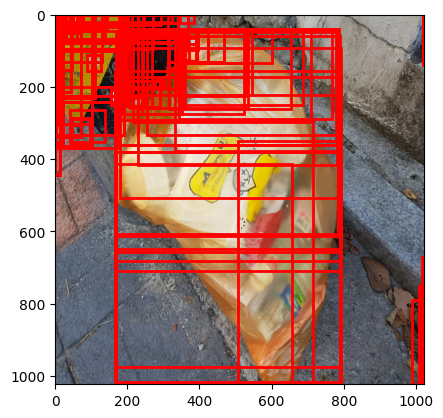

In [9]:
image_path = '/data/ephemeral/home/dataset/train/1149.jpg'
image = Image.open(image_path)
plt.figure()
plt.imshow(image)
ax = plt.gca()
    
for bbox in bbox_P_1149['bbox']:
    
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
plt.show()

In [10]:
display(bbox_P_1149.head())
display(bbox_T_1149.head())

,image_id,category_id,area,bbox,isclowd,id,confidence
0,1149,1,50496.331957,"[342.8173522949219, 61.15715408325195, 392.437...",0,0,0.832823
1,1149,7,812205.125000,"[167.82858276367188, 360.24969482421875, 793.1...",0,1,0.110140
2,1149,7,32399.413990,"[365.6261901855469, 41.36286926269531, 395.595...",0,2,0.093604
3,1149,7,74263.805690,"[205.99795532226562, 184.37374877929688, 291.0...",0,3,0.082686
4,1149,7,70197.963503,"[341.77197265625, 40.843994140625, 529.6159057...",0,4,0.080763


,image_id,category_id,area,bbox,iscrowd,id
5515,1149,7,616279.2,"[165.1, 39.6, 791.4, 1023.6]",0,5515
5516,1149,1,3170.3,"[342.3, 63.7, 391.3, 128.4]",0,5516


## KDTree을 이용하여 근접 bounding box 비교

In [12]:
pred_centers = np.array([
    [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2] 
    for bbox in bbox_P_1149['bbox']
])

from scipy.spatial import KDTree
tree = KDTree(pred_centers)

iou_thresholds = np.arange(0.5, 1.0, 0.05)  # 다양한 IoU 임계값
results = []  # 결과 저장 리스트

In [26]:
iou_threshold = 0.5  # IoU 임계값
tp, fp, fn = [], [], []  # 결과 저장 리스트

# 각 Ground Truth에 대해 매칭 수행
for bbox in bbox_T_1149['bbox']:
    matched_pred = set()  # 매칭된 예측 인덱스

    gt_box = bbox
    gt_center = [(gt_box[0] + gt_box[2]) / 2, (gt_box[1] + gt_box[3]) / 2]
    nearby_pred_indices = tree.query_ball_point(gt_center, r=100)  # 근처 예측 검색
    best_iou = 0
    best_pred = None
    print(nearby_pred_indices)

    for idx_pred in nearby_pred_indices:
        if idx_pred in matched_pred:
            continue  # 이미 매칭된 예측은 건너뜀

        pred_box = bbox_P_1149.iloc[idx_pred]['bbox']
        iou_value = iou(gt_box, pred_box)

        if iou_value > best_iou:
            best_iou = iou_value
            best_pred = idx_pred
        
    if best_iou >= iou_threshold:
        tp.append((gt_box, bbox_P_1149.iloc[best_pred]['bbox']))
        matched_pred.add(best_pred)
    else:
        fn.append(gt_box)

    # 매칭되지 않은 예측을 FP로 처리
    for idx_pred, pred_box in enumerate(bbox_P_1149.iloc[nearby_pred_indices]['bbox']):
        if idx_pred not in matched_pred:
            fp.append(pred_box)


[114, 265, 19, 276, 145]
[218, 191, 103, 86, 12, 282, 0, 280, 243, 17, 68, 272, 117, 75, 9, 35, 2, 10, 207, 141, 194, 83, 49, 199, 164, 4, 169, 16, 136, 33, 275, 252, 183]


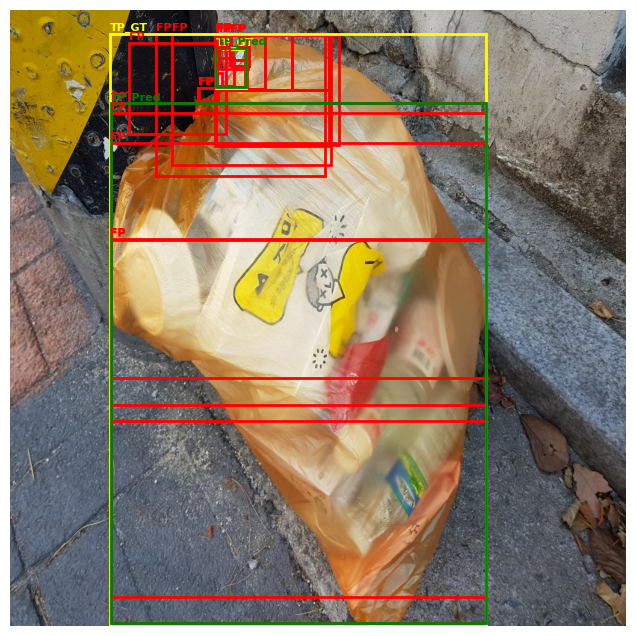

In [27]:
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV 이미지를 RGB로 변환

# 바운딩 박스 그리기 함수
def draw_bbox(ax, bbox, color, label):
    """Matplotlib에서 바운딩 박스 그리기"""
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, 
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 5, label, color=color, fontsize=8, weight='bold')

# 이미지에 바운딩 박스 그리기
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image_rgb)

# TP, FP, FN 바운딩 박스 그리기


for fp_box in fp:
    draw_bbox(ax, fp_box, 'red', 'FP')  # 빨간색: False Positive

for fn_box in fn:
    draw_bbox(ax, fn_box, 'blue', 'FN')  # 파란색: False Negative

for gt_box, pred_box in tp:
    draw_bbox(ax, gt_box, 'yellow', 'TP_GT')  # 초록색: TP의 Ground Truth
    draw_bbox(ax, pred_box, 'green', 'TP_Pred')  # 초록색: TP의 예측 박스

plt.axis('off')  # 축 제거
plt.show()  # 이미지 표시

## prediction 전체 비교

[114, 265, 19, 276, 145]
[218, 191, 103, 86, 12, 282, 0, 280, 243, 17, 68, 272, 117, 75, 9, 35, 2, 10, 207, 141, 194, 83, 49, 199, 164, 4, 169, 16, 136, 33, 275, 252, 183]


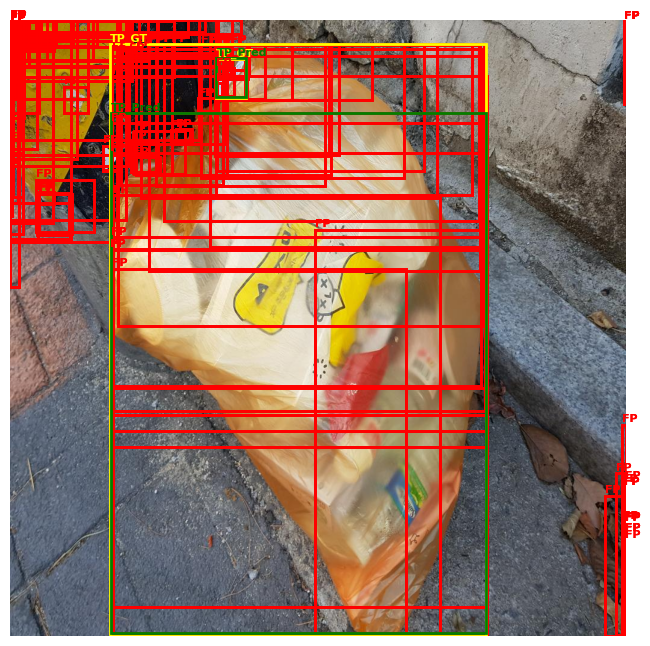

In [28]:
iou_threshold = 0.5  # IoU 임계값
tp, fp, fn = [], [], []  # 결과 저장 리스트

# 각 Ground Truth에 대해 매칭 수행
for bbox in bbox_T_1149['bbox']:
    matched_pred = set()  # 매칭된 예측 인덱스

    gt_box = bbox
    gt_center = [(gt_box[0] + gt_box[2]) / 2, (gt_box[1] + gt_box[3]) / 2]
    nearby_pred_indices = tree.query_ball_point(gt_center, r=100)  # 근처 예측 검색
    best_iou = 0
    best_pred = None
    print(nearby_pred_indices)

    for idx_pred in nearby_pred_indices:
        if idx_pred in matched_pred:
            continue  # 이미 매칭된 예측은 건너뜀

        pred_box = bbox_P_1149.iloc[idx_pred]['bbox']
        iou_value = iou(gt_box, pred_box)

        if iou_value > best_iou:
            best_iou = iou_value
            best_pred = idx_pred
        
    if best_iou >= iou_threshold:
        tp.append((gt_box, bbox_P_1149.iloc[best_pred]['bbox']))
        matched_pred.add(best_pred)
    else:
        fn.append(gt_box)

    # 매칭되지 않은 예측을 FP로 처리
    for idx_pred, pred_box in enumerate(bbox_P_1149['bbox']):
        if idx_pred not in matched_pred:
            fp.append(pred_box)


image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV 이미지를 RGB로 변환

# 바운딩 박스 그리기 함수
def draw_bbox(ax, bbox, color, label):
    """Matplotlib에서 바운딩 박스 그리기"""
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, 
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 5, label, color=color, fontsize=8, weight='bold')

# 이미지에 바운딩 박스 그리기
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image_rgb)

# TP, FP, FN 바운딩 박스 그리기


for fp_box in fp:
    draw_bbox(ax, fp_box, 'red', 'FP')  # 빨간색: False Positive

for fn_box in fn:
    draw_bbox(ax, fn_box, 'blue', 'FN')  # 파란색: False Negative

for gt_box, pred_box in tp:
    draw_bbox(ax, gt_box, 'yellow', 'TP_GT')  # 초록색: TP의 Ground Truth
    draw_bbox(ax, pred_box, 'green', 'TP_Pred')  # 초록색: TP의 예측 박스

plt.axis('off')  # 축 제거
plt.show()  # 이미지 표시

## MVP

TP: 0, FP: 4, FN: 2


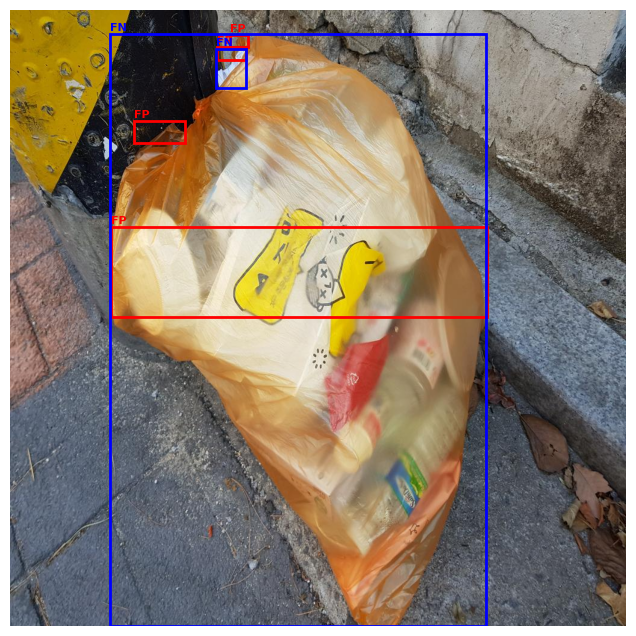

In [47]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import KDTree

def iou(box1, box2):
    """IoU 계산 함수"""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return interArea / float(box1Area + box2Area - interArea)

# 데이터 로드: 예측(Pred)과 Ground Truth(GT) 바운딩 박스 예시
bbox_p_1149 = [
    [342.8, 61.1, 392.4, 83.4],  # 예측 bbox 예시
    [167.9, 360.2, 793.1, 510.2],
    [365.6, 41.3, 395.5, 60.4],
    [206.0, 184.4, 291.0, 220.6]
]

bbox_T_1149 = [
    [342.3, 63.7, 391.3, 128.4],  # Ground Truth bbox 예시
    [165.1, 39.6, 791.4, 1023.6]
]

# 예측 박스의 중심 좌표 계산 및 KDTree 생성
pred_centers = np.array([
    [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2] for box in bbox_p_1149
])
tree = KDTree(pred_centers)

iou_threshold = 0.5  # IoU 임계값
tp, fp, fn = [], [], []  # 결과 저장 리스트
matched_pred = set()  # 매칭된 예측 인덱스

# 각 Ground Truth에 대해 매칭 수행
for gt_box in bbox_T_1149:
    gt_center = [(gt_box[0] + gt_box[2]) / 2, (gt_box[1] + gt_box[3]) / 2]
    nearby_pred_indices = tree.query_ball_point(gt_center, r=50)  # 근처 예측 검색

    best_iou = 0
    best_pred = None

    for idx_pred in nearby_pred_indices:
        if idx_pred in matched_pred:
            continue  # 이미 매칭된 예측은 건너뜀

        pred_box = bbox_p_1149[idx_pred]
        iou_value = iou(gt_box, pred_box)

        if iou_value > best_iou:
            best_iou = iou_value
            best_pred = idx_pred

    if best_iou >= iou_threshold:
        tp.append((gt_box, bbox_p_1149[best_pred]))
        matched_pred.add(best_pred)
    else:
        fn.append(gt_box)

# 매칭되지 않은 예측을 FP로 처리
for idx_pred, pred_box in enumerate(bbox_p_1149):
    if idx_pred not in matched_pred:
        fp.append(pred_box)

# 결과 출력
print(f"TP: {len(tp)}, FP: {len(fp)}, FN: {len(fn)}")

# 이미지 로드 (예시 이미지 경로)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV 이미지를 RGB로 변환

# 바운딩 박스 그리기 함수
def draw_bbox(ax, bbox, color, label):
    """Matplotlib에서 바운딩 박스 그리기"""
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, 
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 5, label, color=color, fontsize=8, weight='bold')

# 이미지에 바운딩 박스 그리기
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image_rgb)

# TP, FP, FN 바운딩 박스 그리기
for gt_box, pred_box in tp:
    draw_bbox(ax, gt_box, 'green', 'TP_GT')  # 초록색: TP의 Ground Truth
    draw_bbox(ax, pred_box, 'green', 'TP_Pred')  # 초록색: TP의 예측 박스

for fp_box in fp:
    draw_bbox(ax, fp_box, 'red', 'FP')  # 빨간색: False Positive

for fn_box in fn:
    draw_bbox(ax, fn_box, 'blue', 'FN')  # 파란색: False Negative

plt.axis('off')  # 축 제거
plt.show()  # 이미지 표시
